# Developing match up function v2

- Move to a 1D model output

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rompy
from rompy import utils ## Should we import utils in __init__.py?
from shapely.geometry import MultiPoint,Point
%matplotlib inline

xr.set_options(display_style = 'text')

In [2]:
cat = rompy.cat
model_ds = cat.csiro.swan.swan_perth_fc.map(fcdate='2021-02').to_dask()

x = model_ds.longitude.values
y = model_ds.latitude.values 
xx,yy = np.meshgrid(x,y)
points = MultiPoint(list(map(Point,zip(xx.ravel(),yy.ravel())))) 
geom = points.convex_hull.buffer(0.01).simplify(tolerance=0.01)
df=cat.aodn.nrt_wave_buoys(startdt='2021-02',enddt='2021-04',geom=geom.to_wkt()).read()
obs = df[['TIME','LATITUDE','LONGITUDE','WHTH']]
obs['TIME'] =  pd.to_datetime(obs['TIME'])
model_ds

/home/whitwell/miniconda3/envs/rompy-dev/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


<xarray.Dataset>
Dimensions:    (latitude: 300, longitude: 160, time: 121)
Coordinates:
  * time       (time) datetime64[ns] 2021-02-01 ... 2021-02-06
  * longitude  (longitude) float32 115.0 115.0 115.0 115.0 ... 115.8 115.8 115.8
  * latitude   (latitude) float32 -33.0 -32.99 -32.99 ... -31.51 -31.51 -31.5
Data variables:
    depth      (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    ubot       (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    hs         (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    hswe       (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    theta0     (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    tps        (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    tm01       (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    xwnd       (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    ywnd       (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.5
    History:                         Created with agioncmd version 1.5
    Directional_convention:          nautical
    project:                         SWAN
    run:                             
    DODS_EXTRA.Unlimited_Dimension:  time

In [3]:
obs

,TIME,LATITUDE,LONGITUDE,WHTH
0,2021-02-01 00:00:00,-32.10,115.40,1.91
1,2021-02-01 15:00:00,-32.10,115.40,1.44
2,2021-02-01 18:00:00,-32.10,115.40,1.43
3,2021-02-02 06:00:00,-32.10,115.40,1.32
4,2021-02-02 09:00:00,-32.10,115.40,1.36
...,...,...,...,...
393,2021-03-25 06:00:00,-32.45,115.57,0.92
394,2021-03-25 12:00:00,-32.45,115.57,1.02
395,2021-03-25 15:00:00,-32.45,115.57,1.08
396,2021-03-29 06:00:00,-32.45,115.57,1.26


In [5]:
out_ds = rompy.utils.find_matchup_data(obs,model_ds,{'WHTH':'hs'},time_thresh=None,KDtree_kwargs={})
out_ds

<xarray.Dataset>
Dimensions:          (observation: 38)
Coordinates:
    time             (observation) datetime64[ns] 2021-02-01 ... 2021-02-05T2...
    longitude        (observation) float32 115.4 115.4 115.4 ... 115.6 115.6
    latitude         (observation) float32 -32.1 -32.1 -32.1 ... -32.45 -32.45
Dimensions without coordinates: observation
Data variables:
    meas_time        (observation) datetime64[ns] 2021-02-01 ... 2021-02-05T2...
    meas_longitude   (observation) float64 115.4 115.4 115.4 ... 115.6 115.6
    meas_latitude    (observation) float64 -32.1 -32.1 -32.1 ... -32.45 -32.45
    meas_whth        (observation) float64 1.91 1.44 1.43 1.32 ... 1.3 1.26 1.31
    model_hs         (observation) float32 1.922 1.919 1.83 ... 1.469 1.547
    model_time       (observation) datetime64[ns] 2021-02-01 ... 2021-02-05T2...
    model_longitude  (observation) float32 115.4 115.4 115.4 ... 115.6 115.6
    model_latitude   (observation) float32 -32.1 -32.1 -32.1 ... -32.45 -32.45
    dist             (observation) float64 0.003217 0.003217 ... 0.002341
Attributes:
    grid:     regular

Text(0.5, 1.0, 'Hs')

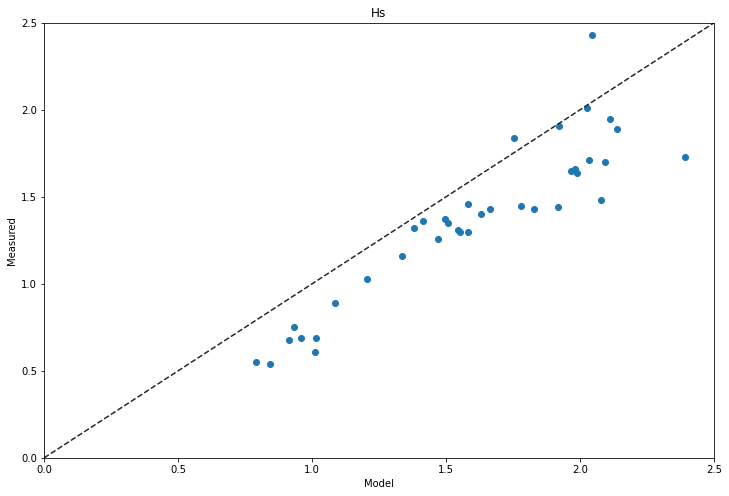

In [7]:
fig, ax  = plt.subplots(figsize=(12,8))

ax.scatter(out_ds['model_hs'],out_ds['meas_whth'])
ax.plot([0,3],[0,3],ls='--',c='#252525')
ax.set_ylim(0,2.5)
ax.set_xlim(0,2.5)
ax.set_xlabel('Model')
ax.set_ylabel('Measured')
ax.set_title('Hs')